In [1]:
%reload_ext autoreload
%autoreload 2

Build a Captcha Solver 
=================

A website uses Captchas on a form to keep the web-bots away. However, the captchas it generates, are quite similar each time:
- the number of characters remains the same each time  
- the font and spacing is the same each time  
- the background and foreground colors and texture, remain largely the same
- there is no skew in the structure of the characters.  
- the captcha generator, creates strictly 5-character captchas, and each of the characters is either an upper-case character (A-Z) or a numeral (0-9).


A sample of 26 captcha has been provided. We are now to build a captch solver to identify the unseen captcha. 

## Solution based on tesseract

Before we can use tesseract, let install tesseract:

```shell
brew install tesseract

brew install tesseract-lang
```

And in the function <em>inference_with_tesseract</em> in the **Captcha** class, restrict tesseract to only look for uppercase letters and digits. Also set --psm 7 so that tesseract treats individual captcha as a single line

```python
    tesseract_results = [pytesseract.image_to_string(Image.open(path), config='--psm 7 --oem 1 -l eng -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789').strip()[:5] for path in batch_data['input_file']] # --oem 1 --tessdata-dir /opt/homebrew/share/tessdata

```


In [2]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from captcha import Captcha
import util

captcha_solver = Captcha(device, "../config.yaml")
preds_tesseract = captcha_solver(mode = "tesseract", im_path = "") # folder with a batch of files 

Preprocess: False


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transfor

Using Tesseract OCR for inference
Generated text 'EGYK4' saved to ../data/output/pred00.txt
Generated text 'GRC35' saved to ../data/output/pred01.txt
Generated text '6OSW1' saved to ../data/output/pred02.txt
Generated text 'J627C' saved to ../data/output/pred03.txt
Generated text 'VLI2C' saved to ../data/output/pred04.txt
Generated text 'O1R70' saved to ../data/output/pred05.txt
Generated text 'OYTAD' saved to ../data/output/pred06.txt
Generated text 'ZRMQU' saved to ../data/output/pred07.txt
Generated text 'NDES' saved to ../data/output/pred08.txt
Generated text '26553' saved to ../data/output/pred09.txt
Generated text 'GZMBA' saved to ../data/output/pred10.txt
Generated text 'YMB10' saved to ../data/output/pred100.txt
Generated text 'J14D' saved to ../data/output/pred11.txt
Generated text 'POSAE' saved to ../data/output/pred12.txt
Generated text 'ZD0' saved to ../data/output/pred13.txt
Generated text 'WGST7' saved to ../data/output/pred14.txt
Generated text 'XKMS2' saved to ../data/o

### Evaluation of tesseract performance

Each sample captcha has a groud truth label already. We will load them and merge with the results and calculate error at both the character level and word level.

In [3]:
# let us look at the predicted text first
from tabulate import tabulate

headers = ['key', 'Image File', 'Output File', 'Prediction']
print(tabulate(preds_tesseract, headers=headers, tablefmt='grid'))

+----+-------+----------------------------+----------------------------+--------------+
|    |   key | Image File                 | Output File                | Prediction   |
+====+=======+============================+============================+==============+
|  0 |    00 | ../data/input/input00.jpg  | ../data/output/pred00.txt  | EGYK4        |
+----+-------+----------------------------+----------------------------+--------------+
|  1 |    01 | ../data/input/input01.jpg  | ../data/output/pred01.txt  | GRC35        |
+----+-------+----------------------------+----------------------------+--------------+
|  2 |    02 | ../data/input/input02.jpg  | ../data/output/pred02.txt  | 6OSW1        |
+----+-------+----------------------------+----------------------------+--------------+
|  3 |    03 | ../data/input/input03.jpg  | ../data/output/pred03.txt  | J627C        |
+----+-------+----------------------------+----------------------------+--------------+
|  4 |    04 | ../data/input/inp

And now load the existing labels. They are in output folder

In [4]:
preds_tesseract_with_labels = captcha_solver.add_gt_labels(preds_tesseract)

headers = ['key','Image File', 'Output File', 'Prediction'  , 'GT Label', 'Correct']
print(tabulate(preds_tesseract_with_labels, headers=headers, tablefmt='grid'))

+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|    |   key | Image File                 | Output File                | Prediction   | GT Label   | Correct   |
+====+=======+============================+============================+==============+============+===========+
|  0 |    00 | ../data/input/input00.jpg  | ../data/output/pred00.txt  | EGYK4        | EGYK4      | True      |
+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|  1 |    01 | ../data/input/input01.jpg  | ../data/output/pred01.txt  | GRC35        | GRC35      | True      |
+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|  2 |    02 | ../data/input/input02.jpg  | ../data/output/pred02.txt  | 6OSW1        | 6O5W1      | False     |
+----+-------+----------------------------+----------------------------+--------------+---------

Let's now analyze the error at both character level and word level, i.e., <em>CER</em> and <em>WER</em>.

Load the library from HF first.

In [5]:
import evaluate

# Load the metric
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

#### CER and WER calculation

Now calculate the CER and WER.

In [6]:
# Calculate CER & WER for all captcha samples
predictions = preds_tesseract_with_labels['prediction'].tolist()
references = preds_tesseract_with_labels['ground_truth'].tolist()

# Compute CER & WER
cer_result = cer_metric.compute(predictions=predictions, references=references)
wer_result = wer_metric.compute(predictions=predictions, references=references)

# Print results
print(f"Overall Character Error Rate (CER): {cer_result:.2%}")
print(f"Overall Word Error Rate (WER): {wer_result:.2%}")

# Detailed analysis per sample
print("\nDetailed Analysis:")
print("=" * 60)
# Iterate through DataFrame rows for detailed analysis
for _, row in preds_tesseract_with_labels.iterrows():
    pred = row['prediction']
    ref = row['ground_truth']
    key = row['key']
    
    # Calculate metrics for this sample
    sample_cer = cer_metric.compute(predictions=[pred], references=[ref])
    sample_wer = wer_metric.compute(predictions=[pred], references=[ref])
    
    # Only show samples with errors
    if sample_cer > 0 or sample_wer > 0:
        print(f"\nSample {key}:")
        print(f"Expected: {ref}")
        print(f"Predicted: {pred}")
        print(f"CER: {sample_cer:.2%}")
        print(f"WER: {sample_wer:.2%}")
        
        # Show character-by-character comparison
        print("Character differences:")
        for j, (c1, c2) in enumerate(zip(ref, pred)):
            if c1 != c2:
                print(f"Position {j}: Expected '{c1}', Got '{c2}'")
        
        # Handle different lengths
        if len(ref) != len(pred):
            print(f"Length mismatch: Expected {len(ref)}, Got {len(pred)}")
            
        # Show image file for reference
        print(f"Image file: {row['input_file']}")

Overall Character Error Rate (CER): 20.00%
Overall Word Error Rate (WER): 53.85%

Detailed Analysis:

Sample 02:
Expected: 6O5W1
Predicted: 6OSW1
CER: 20.00%
WER: 100.00%
Character differences:
Position 2: Expected '5', Got 'S'
Image file: ../data/input/input02.jpg

Sample 05:
Expected: O1R7Q
Predicted: O1R70
CER: 20.00%
WER: 100.00%
Character differences:
Position 4: Expected 'Q', Got '0'
Image file: ../data/input/input05.jpg

Sample 08:
Expected: N9DQS
Predicted: NDES
CER: 40.00%
WER: 100.00%
Character differences:
Position 1: Expected '9', Got 'D'
Position 2: Expected 'D', Got 'E'
Position 3: Expected 'Q', Got 'S'
Length mismatch: Expected 5, Got 4
Image file: ../data/input/input08.jpg

Sample 09:
Expected: ZGJS3
Predicted: 26553
CER: 80.00%
WER: 100.00%
Character differences:
Position 0: Expected 'Z', Got '2'
Position 1: Expected 'G', Got '6'
Position 2: Expected 'J', Got '5'
Position 3: Expected 'S', Got '5'
Image file: ../data/input/input09.jpg

Sample 100:
Expected: YMB1Q
Predic

### Summary

It can be seen that tesseract (LSTM engine, with English) does not achieve very good performance on the sample set. It achieves a CER of 20%, and a WER of 53.85%. For some captcha, it identifies less than 5 characters. 

And with tesseract, preprocessing (cropping the text and remove the background) does not help in improving the performance.

## Solution based on TrOCR, without preprocessing

We will use pre-trained TrOCR from Microsoft for this task. 

TrOCR has a family of pre-trained models, including **trocr-small-printed**, **trocr-base-printed**, **trocr-base-handwritten**, etc. Since we are dealing with clear and consistent texts, we will choose modle fine tuned with printed text, like **trocr-base-printed**. 

We also need to balance inference speed and accuracy. We will go with **trocr-base-printed** first.

In [8]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from captcha_trocr import CaptchaTrOCR
#import util

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


captcha_solver = CaptchaTrOCR(device, "../config.yaml") # run again to reload the config.yaml


Preprocess: False


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

Let's do it without pre-processing of the captha images first. This is a switch that can be set in the config.yaml. In the same config file, we can also change the pretrained model.

```yaml
model: 
    preprocessing: false
    pretrained_path: "microsoft/trocr-base-printed"
```

In [10]:

# captcha_solver("../data/input/input100.jpg","../data/output/100.txt") # individual file


preds_trocr = captcha_solver(im_path = "")

Using TrOCR for inference
Preprocessing turned off


/Users/jsweng/.pyenv/versions/3.10.13/envs/captcha/lib/python3.10/site-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Generated text 'EGYK4' saved to ../data/output/pred00.txt
Generated text 'GRC35' saved to ../data/output/pred01.txt
Generated text '605W1' saved to ../data/output/pred02.txt
Generated text 'J627C' saved to ../data/output/pred03.txt
Generated text 'VL12C' saved to ../data/output/pred04.txt
Generated text '01R70' saved to ../data/output/pred05.txt
Generated text 'OYTAD' saved to ../data/output/pred06.txt
Generated text 'ZRMOU' saved to ../data/output/pred07.txt
Generated text 'N9DOS' saved to ../data/output/pred08.txt
Generated text '2GJ53' saved to ../data/output/pred09.txt
Generated text 'GZMBA' saved to ../data/output/pred10.txt
Generated text 'YMB1Q' saved to ../data/output/pred100.txt
Generated text 'J14DM' saved to ../data/output/pred11.txt
Generated text 'POSAE' saved to ../data/output/pred12.txt
Generated text 'VWZDO' saved to ../data/output/pred13.txt
Generated text 'WGSTZ' saved to ../data/output/pred14.txt
Generated text 'XKMS2' saved to ../data/output/pred15.txt
Generated tex

### Evaluation

Like what we did with tesseract, we will evaluate performance with both CER and WER. 

Let us look at the predictions first


In [11]:
import evaluate

# Load the metric
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [12]:
# let us look at the predicted text first
from tabulate import tabulate

headers = ['key', 'Image File', 'Output File', 'Prediction']
print(tabulate(preds_trocr, headers=headers, tablefmt='grid'))

+----+-------+----------------------------+----------------------------+--------------+
|    |   key | Image File                 | Output File                | Prediction   |
+====+=======+============================+============================+==============+
|  0 |    00 | ../data/input/input00.jpg  | ../data/output/pred00.txt  | EGYK4        |
+----+-------+----------------------------+----------------------------+--------------+
|  1 |    01 | ../data/input/input01.jpg  | ../data/output/pred01.txt  | GRC35        |
+----+-------+----------------------------+----------------------------+--------------+
|  2 |    02 | ../data/input/input02.jpg  | ../data/output/pred02.txt  | 605W1        |
+----+-------+----------------------------+----------------------------+--------------+
|  3 |    03 | ../data/input/input03.jpg  | ../data/output/pred03.txt  | J627C        |
+----+-------+----------------------------+----------------------------+--------------+
|  4 |    04 | ../data/input/inp

In [13]:
preds_trocr_with_labels = captcha_solver.add_gt_labels(preds_trocr)

headers = ['key','Image File', 'Output File', 'Prediction'  , 'GT Label', 'Correct']
print(tabulate(preds_trocr_with_labels, headers=headers, tablefmt='grid'))

+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|    |   key | Image File                 | Output File                | Prediction   | GT Label   | Correct   |
+====+=======+============================+============================+==============+============+===========+
|  0 |    00 | ../data/input/input00.jpg  | ../data/output/pred00.txt  | EGYK4        | EGYK4      | True      |
+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|  1 |    01 | ../data/input/input01.jpg  | ../data/output/pred01.txt  | GRC35        | GRC35      | True      |
+----+-------+----------------------------+----------------------------+--------------+------------+-----------+
|  2 |    02 | ../data/input/input02.jpg  | ../data/output/pred02.txt  | 605W1        | 6O5W1      | False     |
+----+-------+----------------------------+----------------------------+--------------+---------

#### CER and WER calculation

Let's calculate with the TrOCR inference results.

In [14]:
# Calculate CER & WER for all captcha samples
predictions = preds_trocr_with_labels['prediction'].tolist()
references = preds_trocr_with_labels['ground_truth'].tolist()

# Compute CER & WER
cer_result = cer_metric.compute(predictions=predictions, references=references)
wer_result = wer_metric.compute(predictions=predictions, references=references)

# Print results
print(f"Overall Character Error Rate (CER): {cer_result:.2%}")
print(f"Overall Word Error Rate (WER): {wer_result:.2%}")

# Detailed analysis per sample
print("\nDetailed Analysis:")
print("=" * 60)
# Iterate through DataFrame rows for detailed analysis
for _, row in preds_trocr_with_labels.iterrows():
    pred = row['prediction']
    ref = row['ground_truth']
    key = row['key']
    
    # Calculate metrics for this sample
    sample_cer = cer_metric.compute(predictions=[pred], references=[ref])
    sample_wer = wer_metric.compute(predictions=[pred], references=[ref])
    
    # Only show samples with errors
    if sample_cer > 0 or sample_wer > 0:
        print(f"\nSample {key}:")
        print(f"Expected: {ref}")
        print(f"Predicted: {pred}")
        print(f"CER: {sample_cer:.2%}")
        print(f"WER: {sample_wer:.2%}")
        
        # Show character-by-character comparison
        print("Character differences:")
        for j, (c1, c2) in enumerate(zip(ref, pred)):
            if c1 != c2:
                print(f"Position {j}: Expected '{c1}', Got '{c2}'")
        
        # Handle different lengths
        if len(ref) != len(pred):
            print(f"Length mismatch: Expected {len(ref)}, Got {len(pred)}")
            
        # Show image file for reference
        print(f"Image file: {row['input_file']}")

Overall Character Error Rate (CER): 13.85%
Overall Word Error Rate (WER): 50.00%

Detailed Analysis:

Sample 02:
Expected: 6O5W1
Predicted: 605W1
CER: 20.00%
WER: 100.00%
Character differences:
Position 1: Expected 'O', Got '0'
Image file: ../data/input/input02.jpg

Sample 04:
Expected: VLI2C
Predicted: VL12C
CER: 20.00%
WER: 100.00%
Character differences:
Position 2: Expected 'I', Got '1'
Image file: ../data/input/input04.jpg

Sample 05:
Expected: O1R7Q
Predicted: 01R70
CER: 40.00%
WER: 100.00%
Character differences:
Position 0: Expected 'O', Got '0'
Position 4: Expected 'Q', Got '0'
Image file: ../data/input/input05.jpg

Sample 07:
Expected: ZRMQU
Predicted: ZRMOU
CER: 20.00%
WER: 100.00%
Character differences:
Position 3: Expected 'Q', Got 'O'
Image file: ../data/input/input07.jpg

Sample 08:
Expected: N9DQS
Predicted: N9DOS
CER: 20.00%
WER: 100.00%
Character differences:
Position 3: Expected 'Q', Got 'O'
Image file: ../data/input/input08.jpg

Sample 09:
Expected: ZGJS3
Predicted: 2

CER is now 13.85%, and WER is 50%; while the same for tesseract are 20% and 53.85% respectively. 

There is an improvement, though not much. Let's see whether preprocessing can improve further. 

## Solution with TrOCR, with image pre-processing

Let's see whether we can improve the performance with additional pre-processing steps on the captchas. 

Since the number of characters remains the same in each captcha, the font and spacing is the same each time, and the background and foreground colors and texture also remain largely the same, two preprocessing steps could help to enhance the images:

- removing the background by setting threshold
- cropping the image to bound the text only.

**config.yaml** has a switch <em>preprocessing</em>. Setting it to true would turn on pre-processing. **REMEMBER** to turn it on before continue.

```yaml
model: 
    preprocessing: true
    pretrained_path: "microsoft/trocr-base-printed"
```

In [15]:
captcha_solver = CaptchaTrOCR(device, "../config.yaml") # run again to reload the config.yaml

preds_trocr_with_preprocessing = captcha_solver(im_path = "")  

preds_trocr_with_preprocessing_with_labels = captcha_solver.add_gt_labels(preds_trocr_with_preprocessing)


Preprocess: True


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

Using TrOCR for inference
Preprocessing turned on


/Users/jsweng/.pyenv/versions/3.10.13/envs/captcha/lib/python3.10/site-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Generated text 'EGYK4' saved to ../data/output/pred00.txt
Generated text 'GRC35' saved to ../data/output/pred01.txt
Generated text '605W1' saved to ../data/output/pred02.txt
Generated text 'J627C' saved to ../data/output/pred03.txt
Generated text 'VLI2C' saved to ../data/output/pred04.txt
Generated text '01RZQ' saved to ../data/output/pred05.txt
Generated text 'OYTAD' saved to ../data/output/pred06.txt
Generated text 'ZRMQU' saved to ../data/output/pred07.txt
Generated text 'N9DQS' saved to ../data/output/pred08.txt
Generated text 'ZGJ53' saved to ../data/output/pred09.txt
Generated text 'GZMBA' saved to ../data/output/pred10.txt
Generated text 'YMB1Q' saved to ../data/output/pred100.txt
Generated text 'J14DM' saved to ../data/output/pred11.txt
Generated text 'PQ9AE' saved to ../data/output/pred12.txt
Generated text 'VWZDO' saved to ../data/output/pred13.txt
Generated text 'WGST7' saved to ../data/output/pred14.txt
Generated text 'XKMS2' saved to ../data/output/pred15.txt
Generated tex

Let's look at the effect of preprocessing before we further proceed

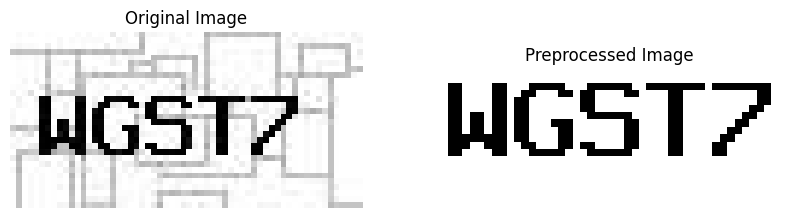

WGST7


In [ ]:
#import util

index = 15
image_path = preds_trocr_with_preprocessing_with_labels['input_file'][index]  # Use the existing image for testing


# Show original, and preprocessed image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Original image
#original = Image.open(image_path)
ax1.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

# Preprocessed image
preprocessed = captcha_solver.preprocess_captcha(image_path)
ax2.imshow(preprocessed)
ax2.set_title('Preprocessed Image')
ax2.axis('off')



plt.show()


# Print the label
print(f"{preds_trocr_with_preprocessing_with_labels['ground_truth'][index]}")

### Evaluation

The prediction from TrOCR after preprocessing. 

In [ ]:
headers = ['key','Image File', 'Output File', 'Prediction'  , 'GT Label', 'Correct']
print(tabulate(preds_trocr_with_preprocessing_with_labels, headers=headers, tablefmt='grid'))

#### CER and WER calculation

In [ ]:
predictions = preds_trocr_with_preprocessing_with_labels['prediction'].tolist()
references = preds_trocr_with_preprocessing_with_labels['ground_truth'].tolist()

# Compute CER & WER
cer_result = cer_metric.compute(predictions=predictions, references=references)
wer_result = wer_metric.compute(predictions=predictions, references=references)

# Print results
print(f"Overall Character Error Rate (CER): {cer_result:.2%}")
print(f"Overall Word Error Rate (WER): {wer_result:.2%}")

# Detailed analysis per sample
print("\nDetailed Analysis:")
print("=" * 60)
# Iterate through DataFrame rows for detailed analysis
for _, row in preds_trocr_with_preprocessing_with_labels.iterrows():
    pred = row['prediction']
    ref = row['ground_truth']
    key = row['key']
    
    # Calculate metrics for this sample
    sample_cer = cer_metric.compute(predictions=[pred], references=[ref])
    sample_wer = wer_metric.compute(predictions=[pred], references=[ref])
    
    # Only show samples with errors
    if sample_cer > 0 or sample_wer > 0:
        print(f"\nSample {key}:")
        print(f"Expected: {ref}")
        print(f"Predicted: {pred}")
        print(f"CER: {sample_cer:.2%}")
        print(f"WER: {sample_wer:.2%}")
        
        # Show character-by-character comparison
        print("Character differences:")
        for j, (c1, c2) in enumerate(zip(ref, pred)):
            if c1 != c2:
                print(f"Position {j}: Expected '{c1}', Got '{c2}'")
        
        # Handle different lengths
        if len(ref) != len(pred):
            print(f"Length mismatch: Expected {len(ref)}, Got {len(pred)}")
            
        # Show image file for reference
        print(f"Image file: {row['input_file']}")

**Good News!!**

With preprocessing turned on, the performance on the 26 samples improved. CER improves from 13.85% to 3.85%, while WER improves from 50% to 15.38%. 

Let's see whether we can do more improvement.


## Data Augmentation

The sample size of 26 is relatively small. We could try to augment the small set by manipulating the original images, e.g., adding noise, changing brightness, etc. We do not apply manipulations like rotation, twist, re-coloring, etc. because the unseen captchas are expected to be similar in terms of numbers of characters, font, spacing, background and foreground color and texture, and skewness. 

**augment_captcha** is the function defined in **util.py** to generate new images based on the existing 26 captcha. New images would be written to <em>data/augmented</em> folder, while the labels are written to <em>data/output</em> folders. 

In [ ]:
import util
augmented_data = util.augment_captcha(preds_trocr_with_preprocessing_with_labels, captcha_solver.aug_dir, captcha_solver.output_dir)

Now apply the TrOCR model on those new images in the <em>data/augmented</em> folder. 

In [ ]:
captcha_solver = Captcha(device, "../config.yaml") # run again to reload the config.yaml

preds_trocr_augmented_with_preprocessing = captcha_solver(mode = "TrOCR", im_path = "../data/augmented")  # let's use the augmented data only

preds_trocr_augmented_with_preprocessing_with_labels = captcha_solver.add_gt_labels(preds_trocr_augmented_with_preprocessing)

### CER and WER calculation

Time to evalaute the CER and WER.

In [ ]:
predictions = preds_trocr_augmented_with_preprocessing_with_labels['prediction'].tolist()
references = preds_trocr_augmented_with_preprocessing_with_labels['ground_truth'].tolist()

# Compute CER & WER
cer_result = cer_metric.compute(predictions=predictions, references=references)
wer_result = wer_metric.compute(predictions=predictions, references=references)

# Print results
print(f"Overall Character Error Rate (CER): {cer_result:.2%}")
print(f"Overall Word Error Rate (WER): {wer_result:.2%}")

# Detailed analysis per sample
print("\nDetailed Analysis:")
print("=" * 60)
# Iterate through DataFrame rows for detailed analysis
for _, row in preds_trocr_augmented_with_preprocessing_with_labels.iterrows():
    pred = row['prediction']
    ref = row['ground_truth']
    key = row['key']
    
    # Calculate metrics for this sample
    sample_cer = cer_metric.compute(predictions=[pred], references=[ref])
    sample_wer = wer_metric.compute(predictions=[pred], references=[ref])
    
    # Only show samples with errors
    if sample_cer > 0 or sample_wer > 0:
        print(f"\nSample {key}:")
        print(f"Expected: {ref}")
        print(f"Predicted: {pred}")
        print(f"CER: {sample_cer:.2%}")
        print(f"WER: {sample_wer:.2%}")
        
        # Show character-by-character comparison
        print("Character differences:")
        for j, (c1, c2) in enumerate(zip(ref, pred)):
            if c1 != c2:
                print(f"Position {j}: Expected '{c1}', Got '{c2}'")
        
        # Handle different lengths
        if len(ref) != len(pred):
            print(f"Length mismatch: Expected {len(ref)}, Got {len(pred)}")
            
        # Show image file for reference
        print(f"Image file: {row['input_file']}")

On the augmented data, the performance on the 78 samples improved. CER drops to 7.95% from 3.85%, while WER drops to 25.64% from 15.38%. 

Let's do a character-level analysis to see which characters are recognized wronly more often.

In [ ]:
import seaborn as sns
import numpy as np

# Create a dictionary to store confusion matrix data
confusion_data = {}

# Iterate through all predictions
for _, row in preds_trocr_augmented_with_preprocessing_with_labels.iterrows():
    pred = row['prediction']
    ref = row['ground_truth']
    
    # Compare characters
    for expected, predicted in zip(ref, pred):
        if expected != predicted:
            # Initialize nested dictionary if needed
            if expected not in confusion_data:
                confusion_data[expected] = {}
            if predicted not in confusion_data[expected]:
                confusion_data[expected][predicted] = 0
            
            # Increment count
            confusion_data[expected][predicted] += 1

# Get all unique characters (both expected and predicted)
all_chars = sorted(set(
    list(confusion_data.keys()) + 
    [char for d in confusion_data.values() for char in d.keys()]
))

# Create confusion matrix
matrix_size = len(all_chars)
confusion_matrix = np.zeros((matrix_size, matrix_size))

# Fill the confusion matrix
for i, expected in enumerate(all_chars):
    if expected in confusion_data:
        for j, predicted in enumerate(all_chars):
            if predicted in confusion_data[expected]:
                confusion_matrix[i, j] = confusion_data[expected][predicted]

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix, 
            xticklabels=all_chars,
            yticklabels=all_chars,
            annot=True,  # Show numbers in cells
            fmt='g',     # Format as integer
            cmap='YlOrRd',  # Yellow to Orange to Red color scheme
            square=True)    # Make cells square

plt.title('Character Recognition Confusion Matrix')
plt.xlabel('Predicted Character')
plt.ylabel('Expected Character')
plt.tight_layout()
plt.show()

# Print summary
print("\nSummary of most common confusions:")
for expected in all_chars:
    if expected in confusion_data and confusion_data[expected]:
        print(f"\nCharacter '{expected}' was mistaken for:")
        sorted_mistakes = sorted(confusion_data[expected].items(), 
                               key=lambda x: x[1], 
                               reverse=True)
        for predicted, count in sorted_mistakes:
            print(f"  - '{predicted}': {count} times")

The heatmap above shows that digit "0" and alphabet "O" confused the model the most. This pair is known to be challenging for CV models, and visually difficult to diffentiate even for human eyes. Other difficult pairs here include "S" and "5", "Z" and "2". 

We could try to fine tune a base model with those augmented data. Due to time constraint, the fine-tuning was not run to complete. Below is the working code used for fine-tuning with torch.

In [ ]:
'''
# split data into train and test
'''

from sklearn.model_selection import train_test_split


# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(
    augmented_data,
    test_size=0.2,  # 20% for test set
    random_state=42  # For reproducibility
)

print(f"Total samples: {len(augmented_data)}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Print sample distribution
def print_distribution(df, name):
    original = len(df[~df['augmented']])
    augmented = len(df[df['augmented']])
    print(f"\n{name} set distribution:")
    print(f"Original images: {original}")
    print(f"Augmented images: {augmented}")
    
print_distribution(train_df, "Training")
print_distribution(test_df, "Test")


In [ ]:
from torch.utils.data import Dataset

class CaptchaDataset(Dataset):
    def __init__(self, dataframe, processor, max_target_length=128):
        """
        Args:
            dataframe: DataFrame containing image paths and labels
            processor: TrOCR processor for image and text processing
            max_target_length: Maximum length for text encoding padding
        """
        self.data = dataframe
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get row from DataFrame
        row = self.data.iloc[idx]
        
        # Load and preprocess image
        image = Image.open(row['input_file']).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # Encode the text label
        labels = self.processor.tokenizer(
            row['ground_truth'],
            padding="max_length",
            max_length=self.max_target_length
        ).input_ids
        
        # Replace padding tokens with -100 for loss calculation
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        
        # Return processed image and encoded labels
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels)
        }
        return encoding

# Create training and validation datasets
train_dataset = CaptchaDataset(train_df, captcha_solver.processor)
test_dataset = CaptchaDataset(test_df, captcha_solver.processor)

# Verify the dataset
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Test a sample
sample = train_dataset[0]
print("\nSample data:")
print(f"Input shape: {sample['pixel_values'].shape}")
print(f"Label shape: {sample['labels'].shape}")

In [ ]:

# Test a single batch
sample = train_dataset[0]

print("\nSample batch:")
print(f"Pixel values shape: {sample['pixel_values'].shape}")
print(f"Labels shape: {sample['labels'].shape}")
print(f"Original text: {train_df['ground_truth'].iloc[0]}")
print(f"Encoded labels: {sample['labels'].tolist()}")
labels = sample['labels']
labels[labels == -100] = captcha_solver.processor.tokenizer.pad_token_id
label_str = captcha_solver.processor.decode(labels, skip_special_tokens=True)
print(label_str)

In [ ]:
'''
# create dataloader
'''

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
'''
# prep for finetuning
'''

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed") # microsoft/trocr-base-stage1 has not been fine-tuned on any dataset. 
model.to(device)

In [ ]:
'''
# make some configurations 
'''

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = captcha_solver.processor.tokenizer.cls_token_id
model.config.pad_token_id = captcha_solver.processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = captcha_solver.processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4



In [ ]:
'''
# fine tuning
'''

from torch.optim import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=0.001)

for epoch in range(100):  
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   

model.save_pretrained("../model")